These are systems with a contact Hamiltonian of the form
$$
H = ps + f(q)s + F(q, t)
$$

We will focus in particular on the Van der Pol oscillator
where $f(q) = - \epsilon (1-q^2)$ and $F(q) = q - \phi(t)$.

In [21]:
from integrators import contact as ic
from integrators.common import rk4
from lienard import integrator as li
from lienard import models as lm

def step6(system, dt, p, q, s, t, a=ic.a_six, stepper=li.step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

def step6e(system, dt, p, q, s, t, a=ic.e_six, stepper=li.step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

Lienard = lm.Lienard
VanDerPol = lm.VanDerPol
FritzhughNagumo = lm.FritzhughNagumo

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as si
from mpl_toolkits import mplot3d

import progressbar
import warnings

In [23]:
def err(x, y):
    errv = np.empty(len(x))
    for i in range(len(x)):
        errv[i] = max(errv[i-1] if i > 0 else 0, np.abs(x[i]-y[i]))
    return errv

def omega(t,e):
    o=((1 - e**2/16. + (17*e**4)/3072. + t**2/24. + (27*e**2*t**2)/128. +
    (781*e**4*t**2)/73728. + (3*t**4)/640. + (149*e**2*t**4)/2048. -
    (339041*e**4*t**4)/3.538944e6 + (5*t**6)/7168. + (559*e**2*t**6)/16384. +
    (4695149*e**4*t**6)/8.4934656e7))/(2*np.pi)
    return o

In [24]:
def compute_periods(system, init, dts, tf):

    periods = np.zeros_like(dts)

    for i,dt in enumerate(dts):

        p,q,s,t = init
        p1,q1,s1,t1 = li.step1(vdp, dt, p, q, s, t)

        t_local_max_hit = []
        # We consider the first hit as the start
        # => Big Fail if we only have one hit
        n_max_hit = -1

        while t1 < tf:
            # You can change the integrator used below
            # with the optional argument mapper=li.cbabc

            # perform the next step
            p2,q2,s2,t2 = li.step1(vdp, dt, p1, q1, s1, t1)

            if s1>s and s1>s2:
                if not t_local_max_hit:
                    # the list is empty, we initialize also the second element to 0,
                    # if there is no second it, we fail in any case by a division by 0...
                    t_local_max_hit = [t1,0.0]
                else:
                    t_local_max_hit[1] = t1
                n_max_hit += 1

            # advance the steps chain
            p,q,s,t = p1,q1,s1,t1
            p1,q1,s1,t1 = p2,q2,s2,t2

        #computate the period by averaging
        if n_max_hit <= 0:
            warnings.warn(f"Only one maximum was hit with dt={dt}. Skipping...")
        else:
            tl, tr = t_local_max_hit
            period = (tr - tl)/n_max_hit
            periods[i] = period
        
    return periods


# Period and frequency vs time step $\epsilon=0$

## TODO
We have to fix the function of the Modified Hamiltonian as $O(\tau^8)$ and
insert a comparison with the different choice of the modified Hamiltonian.

In [36]:
vdp = VanDerPol(0.0, 0.0, 0.0)
dts = np.arange(0.001,0.5,0.001)

# XXX: Long integration with tf tf = 20000 
# to have a result in a human time fix tf = 200
tf = 200

# p0, q0, s0, t0 = 0.0, 1.0, 1.5, 0.0
p0, q0, s0, t0 = 0.0, 2.0, 0.0, 0.0

# Run only unce to generate the file, otherwise load it from disk
try:
    periods = np.load(f"data/eps0-{tf}.npy")
except FileNotFoundError:
    periods = compute_periods(vdp, (p0,q0,s0,t0), dts, tf)
    np.save(f"data/eps0-{tf}", periods)

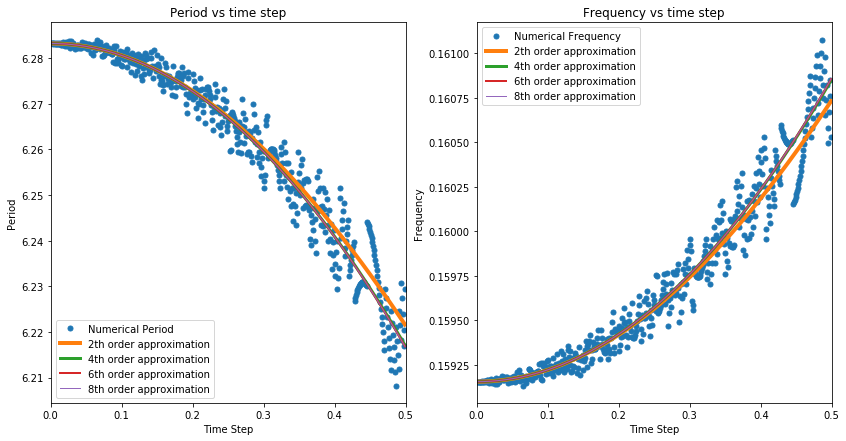

In [31]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods,'.',label="Numerical Period",markersize=10)
plt.plot(dts,1/(np.sqrt((5040 - 420*dts**2)*
                       (1260 + 210*dts**2))/(5040.*np.pi)),
         label="2th order approximation",linewidth=4)
plt.plot(dts,1/(np.sqrt((5040 - 420*dts**2 - 42*dts**4)*
                       (1260 + 210*dts**2 + 42*dts**4))/(5040.*np.pi)),
         label="4th order approximation",linewidth=3)
plt.plot(dts,1/(np.sqrt((5040 - 420*dts**2 - 42*dts**4 - 6*dts**6)*
                       (1260 + 210*dts**2 + 42*dts**4 + 9*dts**6))/(5040.*np.pi)),
         label="6th order approximation",linewidth=2)
plt.plot(dts,1/(np.sqrt((5040 - 420*dts**2 - 42*dts**4 - 6*dts**6 - dts**8)*
                       (1260 + 210*dts**2 + 42*dts**4 + 9*dts**6 + 2*dts**8))/(5040.*np.pi)),
         label="8th order approximation",linewidth=1)
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods,'.',label="Numerical Frequency",markersize=10)
plt.plot(dts,np.sqrt((5040 - 420*dts**2)*
                    (1260 + 210*dts**2))/(5040.*np.pi),
        label="2th order approximation",linewidth=4)
plt.plot(dts,np.sqrt((5040 - 420*dts**2 - 42*dts**4)*
                    (1260 + 210*dts**2 + 42*dts**4))/(5040.*np.pi),
        label="4th order approximation",linewidth=3)
plt.plot(dts,np.sqrt((5040 - 420*dts**2 - 42*dts**4 - 6*dts**6)*
                    (1260 + 210*dts**2 + 42*dts**4 + 9*dts**6))/(5040.*np.pi),
        label="6th order approximation",linewidth=2)
plt.plot(dts,np.sqrt((5040 - 420*dts**2 - 42*dts**4 - 6*dts**6 - dts**8)*
                    (1260 + 210*dts**2 + 42*dts**4 + 9*dts**6 + 2*dts**8))/(5040.*np.pi),
        label="8th order approximation",linewidth=1)
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

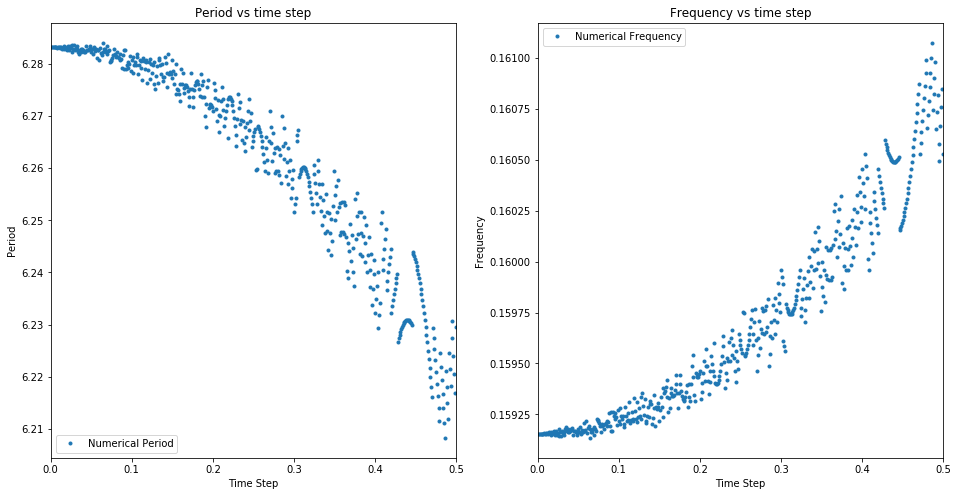

In [30]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

In [14]:
#Long integration with tf tf=20000
#to have a result in a human time fix tf = 200
tf = 20
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
elist=[0]
dt=np.arange(0.001,0.5,0.001)

T=np.zeros(len(dt))


for factor in range(len(dt)):
    t=np.zeros(int(tf))
    tspan = np.arange(0, tf, dt[factor])
    vdp = VanDerPol(0, 0, 0)
    sol, sols, _ = ic.integrate(li.step1, vdp, tspan, p0, q0, s0)
    maxi=np.zeros(int(tf/np.pi))
    ns=int(tf/dt[factor])-1
    j=0
    #computation of periods
    for i in range(ns):
        if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
            #sols[i] is a local nmaximum for s
            maxi[j]=tspan[i]
            j+=1
    for i in range(1,j-1):
        t[i]=(maxi[i+1]-maxi[i])
        T[factor]+=t[i]
    T[factor]=T[factor]/(j-2)
    #j-2 since avoid the first and the last orbit

T[T != 0]
#I don't know how to not print the output

array([6.2835, 6.283 , 6.2835, 6.284 , 6.285 , 6.285 , 6.2825, 6.284 ,
       6.282 , 6.285 , 6.2865, 6.282 , 6.2855, 6.279 , 6.285 , 6.28  ,
       6.2815, 6.282 , 6.2795, 6.28  , 6.2895, 6.281 , 6.279 , 6.288 ,
       6.2875, 6.292 , 6.2775, 6.286 , 6.293 , 6.285 , 6.2775, 6.288 ,
       6.2865, 6.273 , 6.2825, 6.282 , 6.29  , 6.289 , 6.279 , 6.28  ,
       6.273 , 6.279 , 6.278 , 6.292 , 6.2775, 6.302 , 6.298 , 6.288 ,
       6.2965, 6.3   , 6.2985, 6.266 , 6.2805, 6.291 , 6.27  , 6.3   ,
       6.27  , 6.293 , 6.2835, 6.27  , 6.283 , 6.293 , 6.2685, 6.272 ,
       6.305 , 6.303 , 6.298 , 6.29  , 6.279 , 6.3   , 6.2835, 6.3   ,
       6.278 , 6.253 , 6.2625, 6.27  , 6.2755, 6.279 , 6.2805, 6.28  ,
       6.2775, 6.314 , 6.2665, 6.3   , 6.29  , 6.278 , 6.3075, 6.248 ,
       6.2745, 6.3   , 6.279 , 6.302 , 6.2775, 6.298 , 6.27  , 6.288 ,
       6.2565, 6.272 , 6.237 , 6.3   , 6.262 , 6.273 , 6.283 , 6.292 ,
       6.2475, 6.307 , 6.2595, 6.264 , 6.2675, 6.27  , 6.327 , 6.272 ,
      

## Period and frequency vs time step $\epsilon\sim1$.

## $\epsilon = 0.1$

In [10]:
#Long integration with tf tf=20000
#to have a result in a human time fix tf = 200
tf = 20000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
epsilon=0.1
dt=np.arange(0.001,0.5,0.001)

T=np.zeros(len(dt))


for factor in range(len(dt)):
    t=np.zeros(int(tf))
    tspan = np.arange(0, tf, dt[factor])
    vdp = VanDerPol(epsilon, 0, 0)
    sol, sols, _ = ic.integrate(li.step1, vdp, tspan, p0, q0, s0)
    maxi=np.zeros(int(tf/3))
    ns=int(tf/dt[factor])-1
    j=0
    #computation of periods
    for i in range(ns):
        if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
            #sols[i] is a local nmaximum for s
            maxi[j]=tspan[i]
            j+=1
    for i in range(1,j-1):
        t[i]=(maxi[i+1]-maxi[i])
        T[factor]+=t[i]
    T[factor]=T[factor]/(j-2)
    #j-2 since avoid the first and the last orbit

T[T != 0]
#I don't know how to not print the output

array([6.28711101, 6.28711006, 6.28710849, 6.28710692, 6.28710535,
       6.28710189, 6.28709623, 6.28709182, 6.28708868, 6.28708491,
       6.28707767, 6.2870717 , 6.28706572, 6.2870566 , 6.28705189,
       6.28703899, 6.28703302, 6.28702075, 6.28701038, 6.287     ,
       6.28698396, 6.28697736, 6.28697044, 6.28695094, 6.28694182,
       6.28692264, 6.28690755, 6.28688931, 6.28688082, 6.28686792,
       6.28684874, 6.2868327 , 6.28681132, 6.28679245, 6.28677044,
       6.28675472, 6.28674214, 6.28671761, 6.28668962, 6.28666667,
       6.28664088, 6.28662075, 6.2866    , 6.28658994, 6.2865566 ,
       6.28652201, 6.28651604, 6.28647547, 6.28645346, 6.28643082,
       6.28640755, 6.28637484, 6.28633333, 6.28632023, 6.28628028,
       6.28625102, 6.28620887, 6.28618559, 6.2861447 , 6.28610884,
       6.28608934, 6.28604718, 6.28600881, 6.28599182, 6.28596414,
       6.28590311, 6.28588141, 6.28583957, 6.28579365, 6.28575786,
       6.2857327 , 6.28566792, 6.28564434, 6.28560189, 6.28554

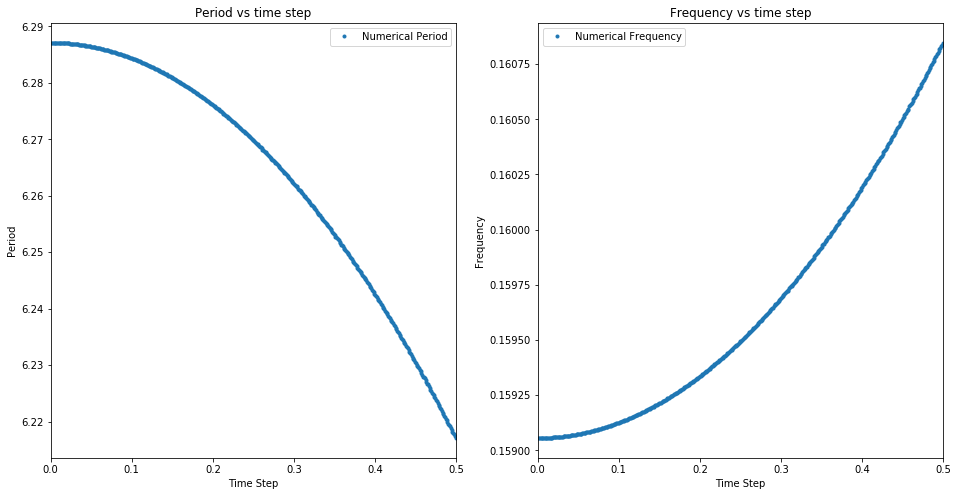

In [11]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

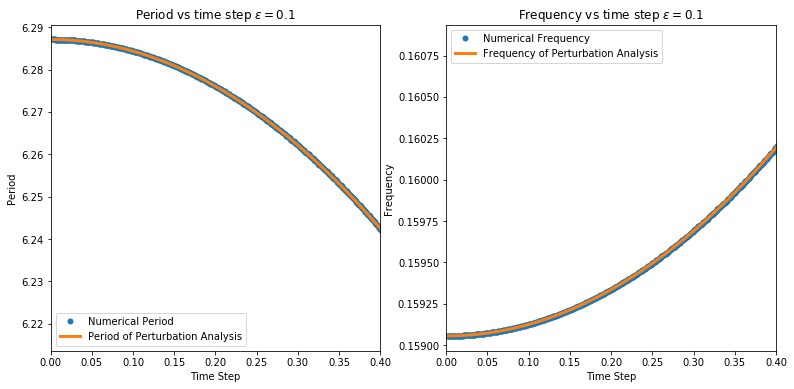

In [13]:
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.gca().set_title("Period vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,T,'.',label="Numerical Period",markersize=10)
plt.plot(dt,1/(omega(dt,epsilon)),
         label="Period of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,1/T,'.',label="Numerical Frequency",markersize=10)
plt.plot(dt,omega(dt,epsilon),
         label="Frequency of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.xlim((0,0.4))
plt.legend(loc='upper left')
plt.show()

## $\epsilon = 0.5$  

In [14]:
#Long integration with tf tf=20000
#to have a result in a human time fix tf = 200
tf = 20000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
epsilon=0.5
dt=np.arange(0.001,0.5,0.001)

T=np.zeros(len(dt))


for factor in range(len(dt)):
    t=np.zeros(int(tf))
    tspan = np.arange(0, tf, dt[factor])
    vdp = VanDerPol(epsilon, 0, 0)
    sol, sols, _ = ic.integrate(li.step1, vdp, tspan, p0, q0, s0)
    maxi=np.zeros(int(tf/3))
    ns=int(tf/dt[factor])-1
    j=0
    #computation of periods
    for i in range(ns):
        if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
            #sols[i] is a local nmaximum for s
            maxi[j]=tspan[i]
            j+=1
    for i in range(1,j-1):
        t[i]=(maxi[i+1]-maxi[i])
        T[factor]+=t[i]
    T[factor]=T[factor]/(j-2)
    #j-2 since avoid the first and the last orbit

T[T != 0]
#I don't know how to not print the output

array([6.38067507, 6.38067348, 6.3806706 , 6.38066518, 6.38066071,
       6.38065432, 6.38064635, 6.38063709, 6.38062656, 6.38061602,
       6.38060038, 6.38059004, 6.38057184, 6.38055364, 6.3805364 ,
       6.38052107, 6.3804984 , 6.38047701, 6.38045115, 6.38042784,
       6.38040613, 6.38037931, 6.38035568, 6.38032184, 6.38028416,
       6.38025223, 6.38022414, 6.38020051, 6.38015741, 6.38012452,
       6.3800811 , 6.38004598, 6.38      , 6.37996105, 6.37992337,
       6.37988254, 6.37982509, 6.37979125, 6.37974274, 6.3796872 ,
       6.37964188, 6.37958953, 6.37953159, 6.37948054, 6.37941768,
       6.37936631, 6.3793277 , 6.37925207, 6.37919336, 6.3791321 ,
       6.37906828, 6.37900957, 6.37894065, 6.37887492, 6.37880664,
       6.37874665, 6.37867103, 6.378612  , 6.3785158 , 6.37846154,
       6.3783843 , 6.37830195, 6.37822215, 6.37816278, 6.37807054,
       6.37800575, 6.37791669, 6.37783153, 6.37774442, 6.37766114,
       6.37756254, 6.37747751, 6.37740574, 6.37731292, 6.37722

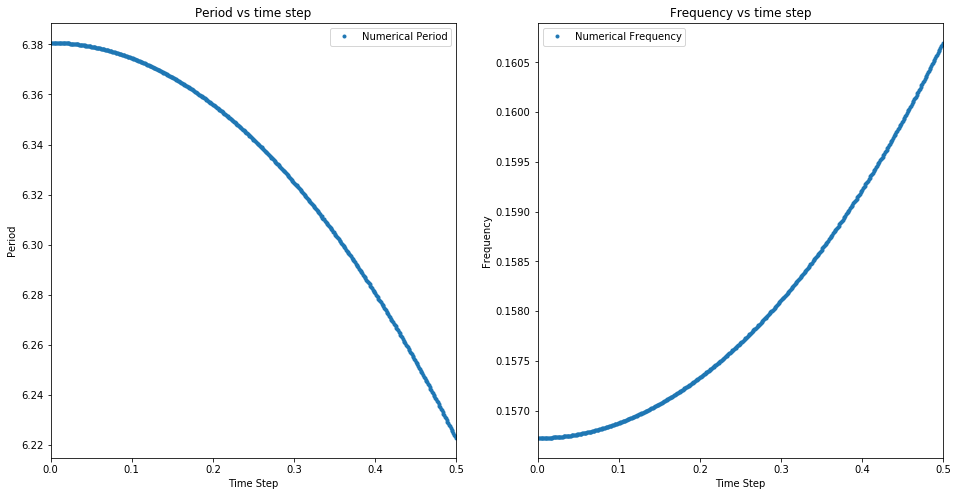

In [15]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

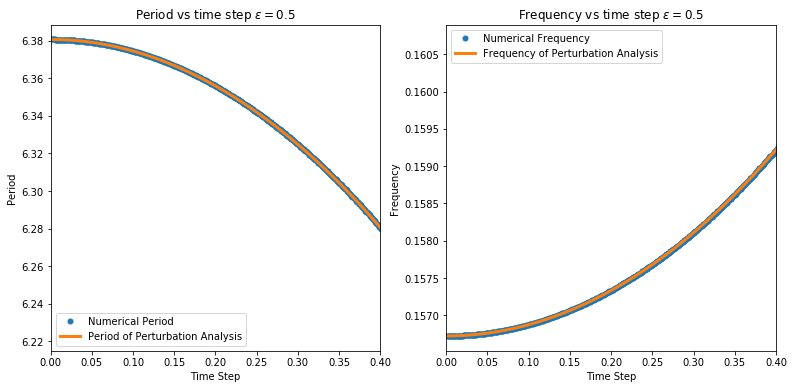

In [16]:
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.gca().set_title("Period vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,T,'.',label="Numerical Period",markersize=10)
plt.plot(dt,1/(omega(dt,epsilon)),
         label="Period of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,1/T,'.',label="Numerical Frequency",markersize=10)
plt.plot(dt,omega(dt,epsilon),
         label="Frequency of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.xlim((0,0.4))
plt.legend(loc='upper left')
plt.show()

## $\epsilon = 0.9$

In [17]:
#Long integration with tf tf=20000
#to have a result in a human time fix tf = 200
tf = 20000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
epsilon=0.9
dt=np.arange(0.001,0.5,0.001)

T=np.zeros(len(dt))


for factor in range(len(dt)):
    t=np.zeros(int(tf))
    tspan = np.arange(0, tf, dt[factor])
    vdp = VanDerPol(epsilon, 0, 0)
    sol, sols, _ = ic.integrate(li.step1, vdp, tspan, p0, q0, s0)
    maxi=np.zeros(int(tf/3))
    ns=int(tf/dt[factor])-1
    j=0
    #computation of periods
    for i in range(ns):
        if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
            #sols[i] is a local nmaximum for s
            maxi[j]=tspan[i]
            j+=1
    for i in range(1,j-1):
        t[i]=(maxi[i+1]-maxi[i])
        T[factor]+=t[i]
    T[factor]=T[factor]/(j-2)
    #j-2 since avoid the first and the last orbit

T[T != 0]
#I don't know how to not print the output

array([6.59323219, 6.59322823, 6.59322032, 6.59320976, 6.59319756,
       6.59318074, 6.59315963, 6.5931372 , 6.59311445, 6.59308377,
       6.59305244, 6.59301617, 6.59297724, 6.59293764, 6.59289838,
       6.59284988, 6.59279743, 6.59275091, 6.59269284, 6.59263609,
       6.59256582, 6.5925094 , 6.59244045, 6.59237479, 6.59229627,
       6.59221768, 6.59214083, 6.59206069, 6.59197164, 6.59187933,
       6.59178767, 6.59169403, 6.59158952, 6.59150478, 6.59138971,
       6.59128783, 6.59117244, 6.59106429, 6.59094857, 6.59083113,
       6.59072296, 6.59059235, 6.5904591 , 6.59032058, 6.5901847 ,
       6.59006135, 6.58991757, 6.58977983, 6.58962788, 6.58948583,
       6.58933784, 6.58917469, 6.5890145 , 6.58885432, 6.58868447,
       6.58852094, 6.58835806, 6.58819189, 6.58800264, 6.58783784,
       6.58765821, 6.58748468, 6.58726755, 6.58710774, 6.58688797,
       6.58669127, 6.58649308, 6.58629532, 6.5861114 , 6.58588332,
       6.58568863, 6.58544975, 6.5852444 , 6.58502503, 6.58480

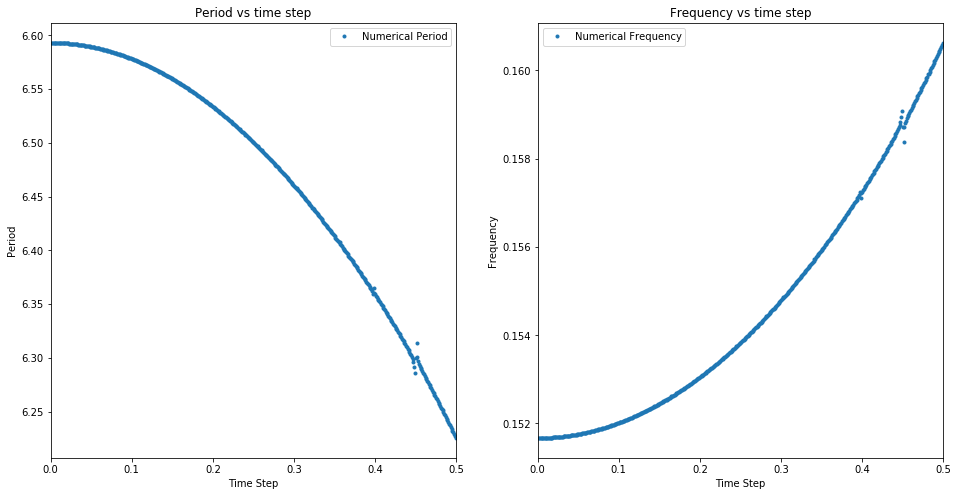

In [18]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

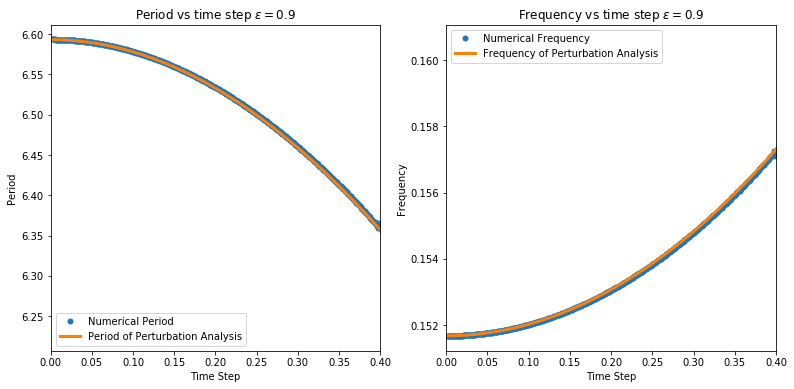

In [19]:
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.gca().set_title("Period vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,T,'.',label="Numerical Period",markersize=10)
plt.plot(dt,1/(omega(dt,epsilon)),
         label="Period of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,1/T,'.',label="Numerical Frequency",markersize=10)
plt.plot(dt,omega(dt,epsilon),
         label="Frequency of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.xlim((0,0.4))
plt.legend(loc='upper left')
plt.show()

## $\epsilon = 1.1$

In [21]:
#Long integration with tf tf=20000
#to have a result in a human time fix tf = 200
tf = 20000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
epsilon=1.1
dt=np.arange(0.001,0.5,0.001)

T=np.zeros(len(dt))


for factor in range(len(dt)):
    t=np.zeros(int(tf))
    tspan = np.arange(0, tf, dt[factor])
    vdp = VanDerPol(epsilon, 0, 0)
    sol, sols, _ = ic.integrate(li.step1, vdp, tspan, p0, q0, s0)
    maxi=np.zeros(int(tf/np.pi))
    ns=int(tf/dt[factor])-1
    j=0
    #computation of periods
    for i in range(ns):
        if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
            #sols[i] is a local nmaximum for s
            maxi[j]=tspan[i]
            j+=1
    for i in range(1,j-1):
        t[i]=(maxi[i+1]-maxi[i])
        T[factor]+=t[i]
    T[factor]=T[factor]/(j-2)
    #j-2 since avoid the first and the last orbit

T[T != 0]
#I don't know how to not print the output

array([6.73941956, 6.73941315, 6.73940236, 6.73938752, 6.73936594,
       6.73934165, 6.73931433, 6.73928094, 6.7392425 , 6.73920067,
       6.73915278, 6.73910287, 6.73904654, 6.73899089, 6.7389258 ,
       6.73885464, 6.73878624, 6.738706  , 6.7386261 , 6.73853724,
       6.73845197, 6.73835457, 6.73825581, 6.73815167, 6.73804348,
       6.73793461, 6.73781496, 6.73769464, 6.7375787 , 6.73744186,
       6.73730546, 6.73716521, 6.73701787, 6.73687188, 6.73672117,
       6.73656372, 6.73641928, 6.73624259, 6.73608053, 6.73590296,
       6.73571429, 6.73553774, 6.7353531 , 6.73515768, 6.73496967,
       6.73477519, 6.73457567, 6.73434985, 6.73414858, 6.73391714,
       6.73370057, 6.73348333, 6.73324924, 6.73301246, 6.7327746 ,
       6.7325283 , 6.73227999, 6.73202561, 6.73176288, 6.73149495,
       6.73123704, 6.73096633, 6.73069091, 6.73041159, 6.73013809,
       6.72984372, 6.72955219, 6.72927634, 6.72895153, 6.72864692,
       6.72836722, 6.72802424, 6.72772424, 6.72739953, 6.72706

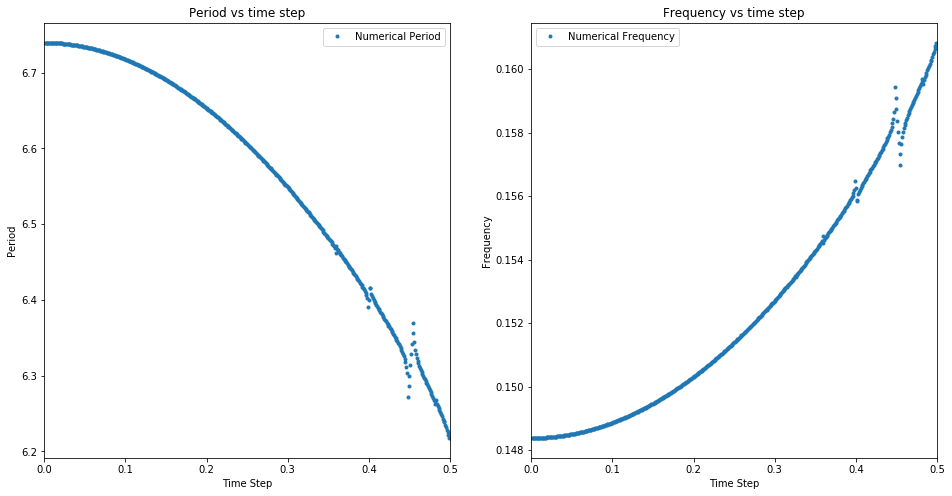

In [22]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

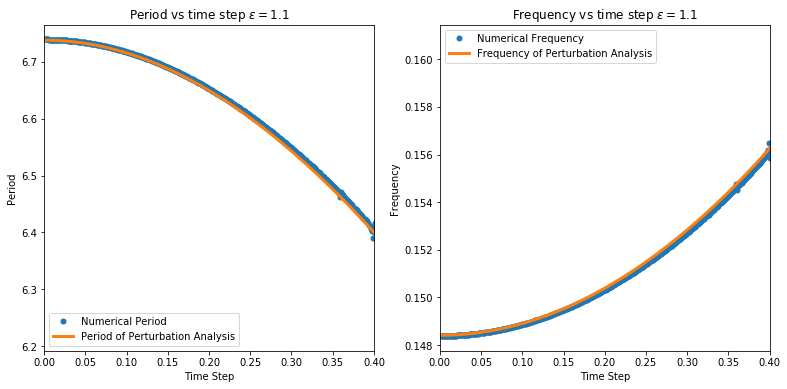

In [23]:
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.gca().set_title("Period vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,T,'.',label="Numerical Period",markersize=10)
plt.plot(dt,1/(omega(dt,epsilon)),
         label="Period of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,1/T,'.',label="Numerical Frequency",markersize=10)
plt.plot(dt,omega(dt,epsilon),
         label="Frequency of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.xlim((0,0.4))
plt.legend(loc='upper left')
plt.show()

## too long things

In [9]:
tf = 10000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
elist=[0.1,0.3,
       0.5,0.7,
       0.9,1.1,
       1.3,1.5,
       1.7,1.9]
dt=np.arange(0.001,0.5,0.001)
T=np.zeros((len(dt),len(elist)))
k=-1

for epsilon in elist:
    k+=1
    for factor in range(len(dt)):
        t=np.zeros(int(tf))
        tspan = np.arange(0, tf, dt[factor])
        vdp = VanDerPol(epsilon, 0, 0)
        sol, sols, _ = ic.integrate(li.step1, vdp, tspan, p0, q0, s0)
        maxi=np.zeros(5000)
        ns=int(tf/dt[factor])-1
        j=0
        for i in range(ns):
            if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
                maxi[j]=tspan[i]
                j+=1
        for i in range(1,j-1):
            t[i]=(maxi[i+1]-maxi[i])
            T[factor,k]+=t[i]
        T[factor,k]=T[factor,k]/(j-2)

T[T != 0]    

KeyboardInterrupt: 

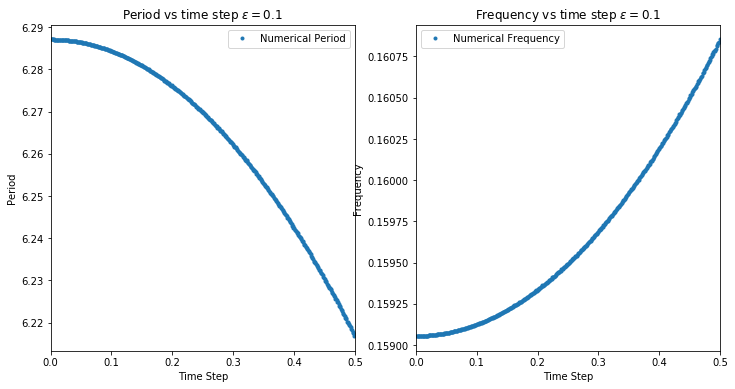

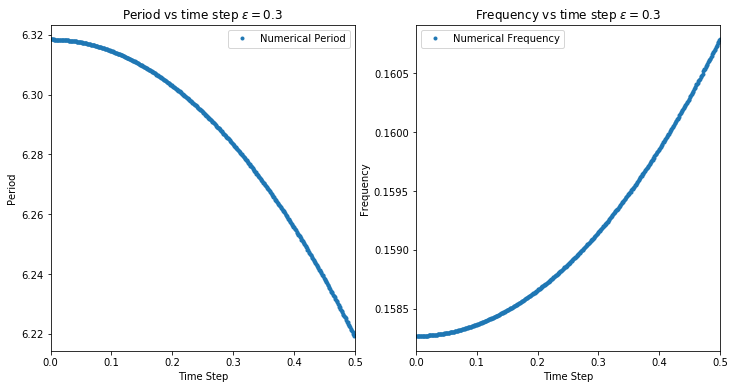

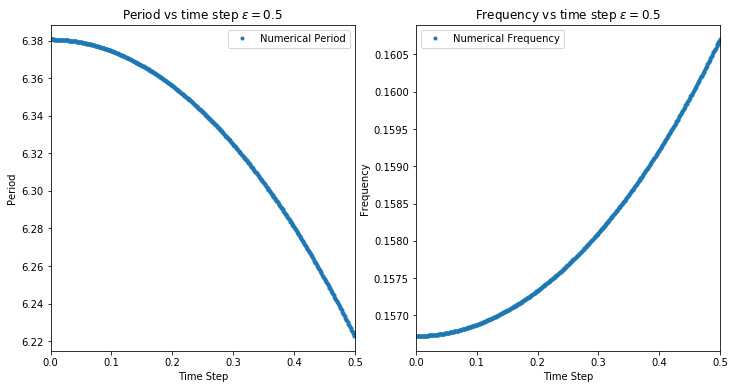

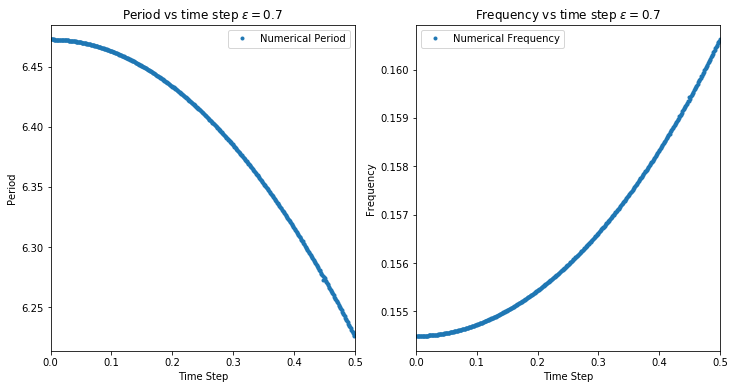

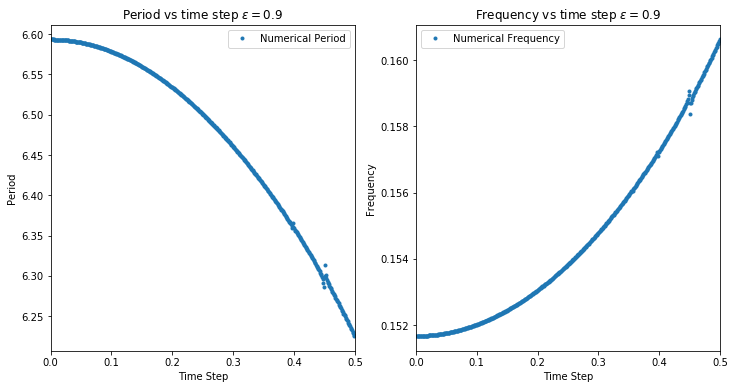

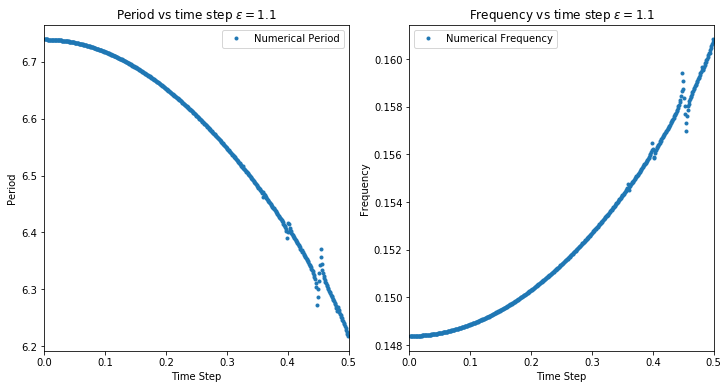

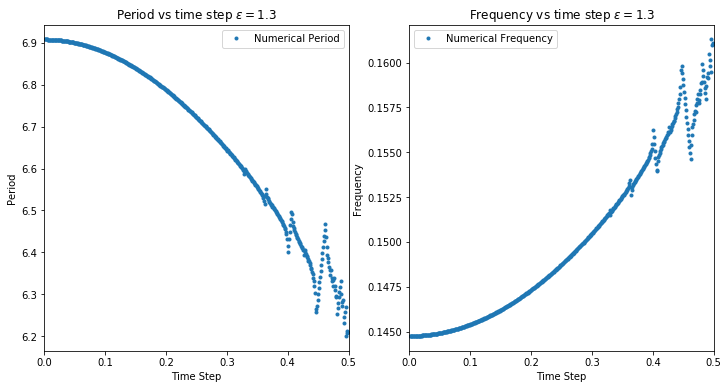

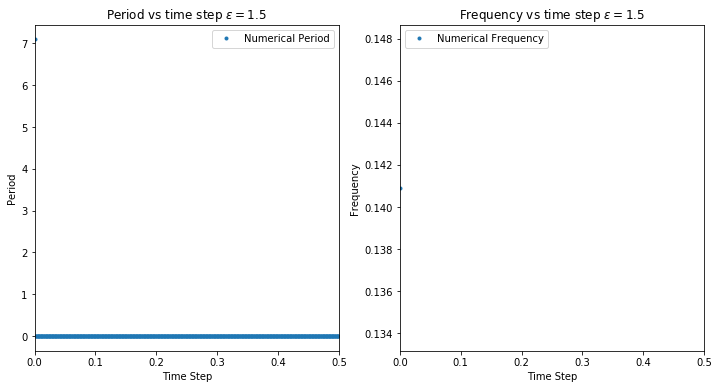

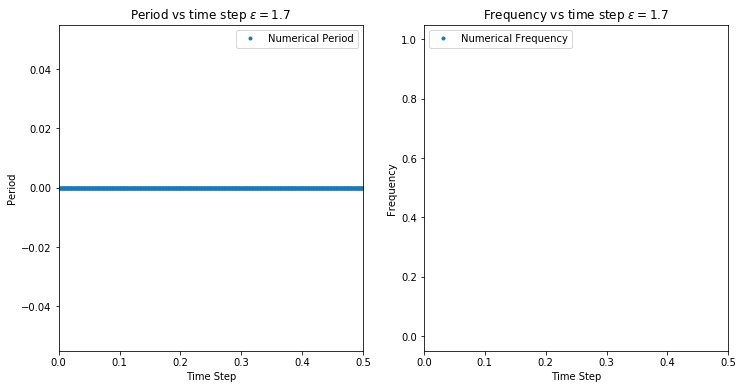

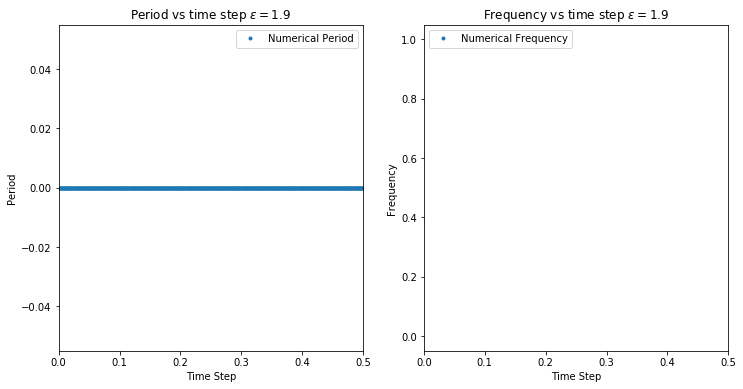

In [35]:
elist=[0.1,0.3,
       0.5,0.7,
       0.9,1.1,
       1.3,1.5,
       1.7,1.9]
for i in range(len(elist)):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.gca().set_title("Period vs time step " r"$\epsilon = " f"${elist[i]}")
    plt.plot(dt,T[:,i],'.',label="Numerical Period")
    plt.xlim((0,0.5))
    plt.ylabel("Period")
    plt.xlabel("Time Step")
    plt.legend(loc='bottom left')

    plt.subplot(122)
    plt.gca().set_title("Frequency vs time step " r"$\epsilon = " f"${elist[i]}")
    plt.plot(dt,1/T[:,i],'.',label="Numerical Frequency")
    plt.xlim((0,0.5))
    plt.ylabel("Frequency")
    plt.xlabel("Time Step")
    plt.legend(loc='upper left')
    plt.show()

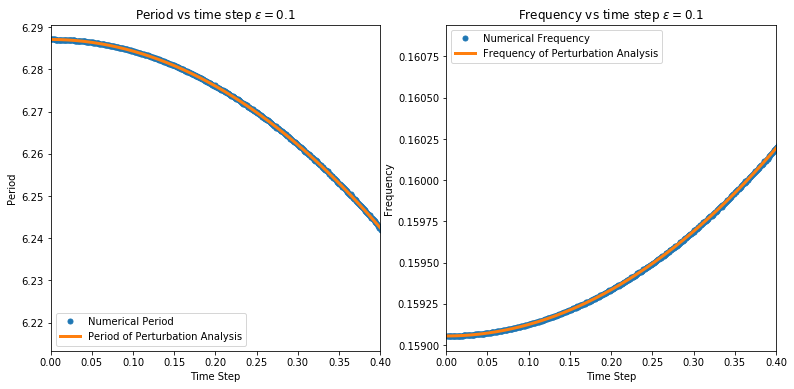

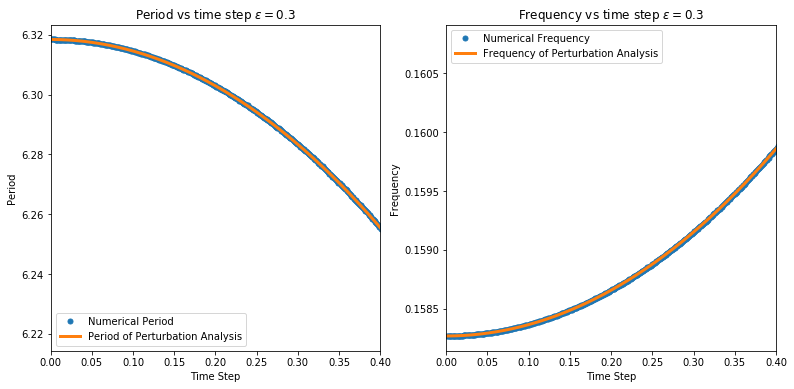

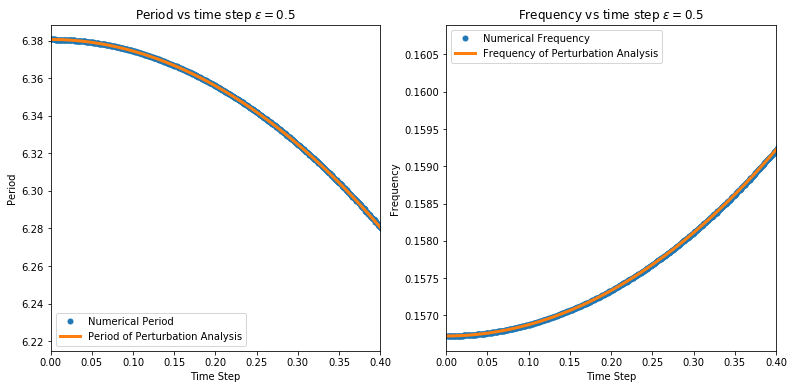

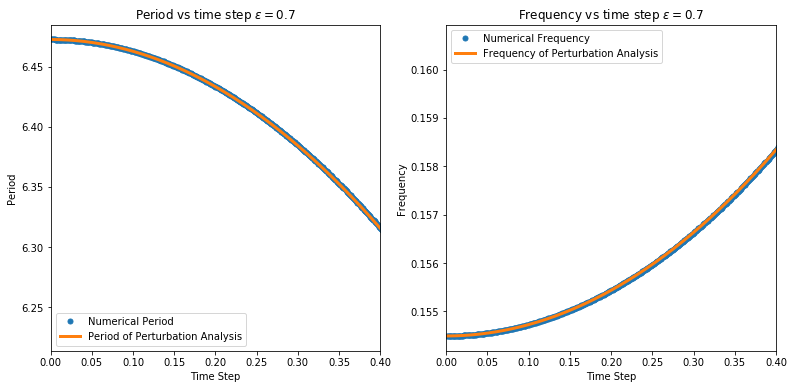

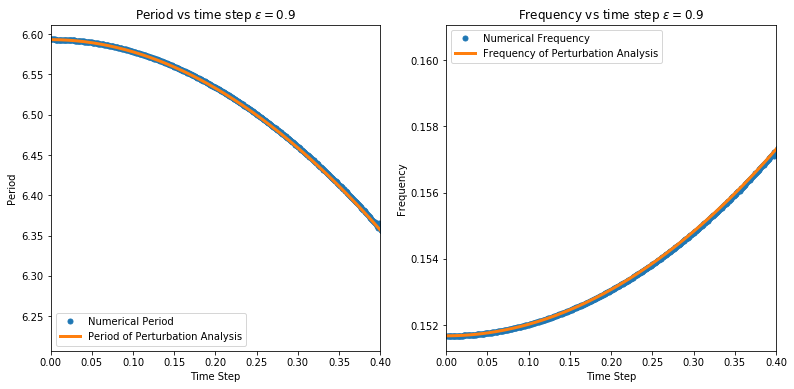

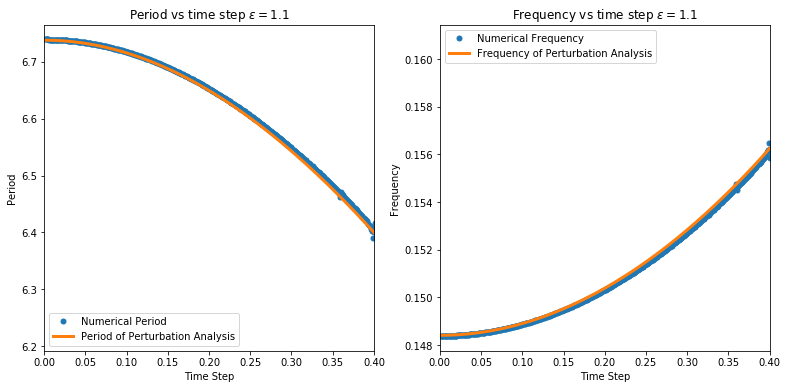

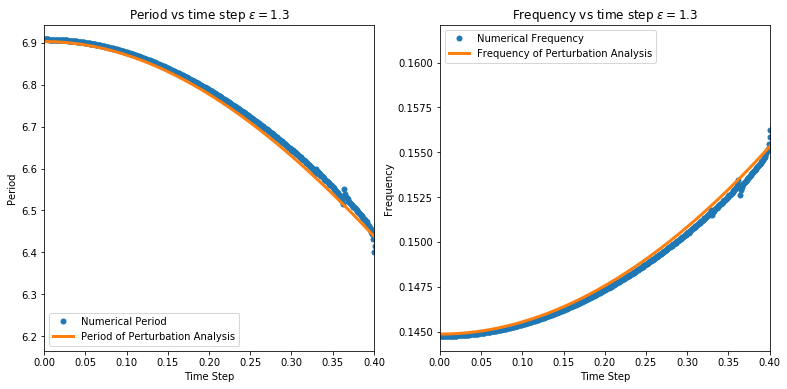

In [38]:
for i in range(len(elist)-3):
    plt.figure(figsize=(13,6))
    epsilon=elist[i]
    plt.subplot(121)
    plt.gca().set_title("Period vs time step " r"$\epsilon = " f"${epsilon}")
    plt.plot(dt,T[:,i],'.',label="Numerical Period",markersize=10)
    plt.plot(dt,1/(omega(dt,epsilon)),
             label="Period of Perturbation Analysis",
             linewidth=3)
    plt.xlim((0,0.4))
    plt.ylabel("Period")
    plt.xlabel("Time Step")
    plt.legend(loc='lower left')

    plt.subplot(122)
    plt.gca().set_title("Frequency vs time step " r"$\epsilon = " f"${epsilon}")
    plt.plot(dt,1/T[:,i],'.',label="Numerical Frequency",markersize=10)
    plt.plot(dt,omega(dt,epsilon),
             label="Frequency of Perturbation Analysis",
             linewidth=3)
    plt.xlim((0,0.4))
    plt.ylabel("Frequency")
    plt.xlabel("Time Step")
    plt.xlim((0,0.4))
    plt.legend(loc='upper left')
    plt.show()